In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import sonnet as snt
import tqdm.notebook as tqdm

from util.expectiles import expectile

print(f"Python version:      {sys.version.split()[0]}")
print(f"NumPy version:       {np.__version__}")
print(f"TensorFlow version:  {tf.__version__}")
print(f" Eager execution:     {tf.executing_eagerly()}")
print(f" GPU availability:    {bool(tf.config.experimental.list_physical_devices('GPU'))}")
print(f"Sonnet version:      {snt.__version__}")

Python version:      3.8.2
NumPy version:       1.18.1
TensorFlow version:  2.2.0-rc4
 Eager execution:     True
 GPU availability:    False
Sonnet version:      2.0.0


loading...
plotting...


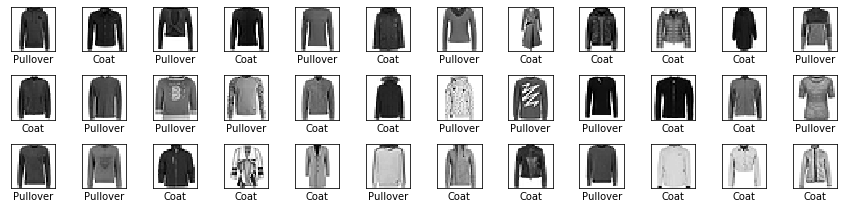

In [2]:
def fmnist_dataset(split, batch_size, labels_to_keep):
    def label_mask(images, labels):
        mask = tf.zeros(labels.shape, tf.bool)
        for label in labels_to_keep:
            mask |= (labels == label)
        return mask
    def preprocess(images, labels):
        images = ((tf.cast(images, tf.float32) / 255.) - .5) * 2.
        return images, labels
    # load the dataset
    dataset, dataset_info = tfds.load(name="fashion_mnist", split=split,
                shuffle_files=True, as_supervised=True, with_info=True)
    dataset_size = dataset_info.splits[split].num_examples
    
    # filter out unused labels
    dataset = dataset.filter(label_mask)
    # transform images
    dataset = dataset.map(preprocess)
    # shuffle, and batch
    dataset = dataset.shuffle(buffer_size=4*batch_size)
    dataset = dataset.batch(batch_size)
    # cache the data pipeline result
    dataset = dataset.cache()
    # 'prefetch batches onto the GPU', 'automatically determine how much
    # to prefetch as this will depend on the GPU'
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset, dataset_size

print("loading...")
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
LABELS_TO_KEEP = [2, 4]
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1000
TRAIN_DATA, NUM_TRAIN_EXAMPLES = fmnist_dataset(split="train",
            batch_size=TRAIN_BATCH_SIZE, labels_to_keep=LABELS_TO_KEEP)
TEST_DATA, NUM_TEST_EXAMPLES = fmnist_dataset(split="test",
            batch_size=TEST_BATCH_SIZE, labels_to_keep=LABELS_TO_KEEP)

print("plotting...")
n, m = 3, 12
plt.figure(figsize=(m, n))
for i, (image, label) in enumerate(TEST_DATA.unbatch().take(n*m), 1):
    plt.subplot(n, m, i)
    plt.imshow(tf.squeeze(image), cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[label])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [3]:
NUM_REDUCED_IMAGES = 12000
NUM_EPOCHS = 4
LEARNING_RATE = 0.005

def train(model, labels_rewards, loss_fn, data=TRAIN_DATA,
          num_items=NUM_REDUCED_IMAGES, num_epochs=NUM_EPOCHS,
          learning_rate=LEARNING_RATE, **loss_kwargs):
    progress = tqdm.tqdm(total=num_items*num_epochs, unit="images")
    loss_log = []
    loss_log_2 = []
    optimizer = snt.optimizers.SGD(learning_rate=learning_rate)
    for minibatch in data.repeat(num_epochs):
        images, labels = minibatch
        # generate rewards for batch
        rewards = np.zeros(labels.shape[0])
        for label, rs in labels_rewards.items():
            ids = np.where(labels == label)
            num = ids[0].size
            rewards[ids] = np.random.choice(rs, num)
        rewards = tf.convert_to_tensor(rewards, tf.float32)
        # predict rewards, compute loss
        with tf.GradientTape() as tape:
            value_predictions = model(images)
            loss = loss_fn(value_predictions, rewards, **loss_kwargs)
        # apply update
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply(gradients, variables)
        # track progress
        print(f"loss {loss.numpy():15.3f}", end="\r")
        loss_log.append(loss.numpy())
        # NOTE: probably we want to track the non-distributional loss
        # HACK:
        if loss_kwargs:
            loss_log_2.append(traditional_TD_loss(value_predictions[:, 1], rewards).numpy())
        else:
            loss_log_2.append(loss.numpy())
        progress.update(n=labels.shape[0])
    print(f"loss {loss.numpy():15.3f} (done)")
    progress.close()
    return model, loss_log, loss_log_2

def create_model(n_outputs=1):
    model = snt.Sequential([
        snt.Conv2D(32, 3, 1),
        tf.nn.relu,
        snt.Conv2D(32, 3, 1),
        tf.nn.relu,
        snt.Flatten(),
        snt.Linear(10),
        tf.nn.relu,
        snt.Linear(n_outputs)
    ])
    return model

def traditional_TD_loss(value_predictions, rewards):
    # loss is mean squared reward-prediction error
    rpe = tf.subtract(rewards, value_predictions)
    loss = tf.reduce_mean(tf.square(rpe))
    return loss

def expectile_distributional_TD_loss(value_predictions, rewards, tau_factors):
    rpes = tf.subtract(rewards[:, tf.newaxis], value_predictions)
    loss = tf.reduce_mean(tf.pow(tau_factors, tf.sign(rpes)) * tf.square(rpes))
    return loss

N_ATOMS = 64
TAUS = np.linspace(0.05, 0.95, N_ATOMS)
TAU_FACTORS = tf.convert_to_tensor(np.sqrt(TAUS/(1-TAUS)), tf.float32)

PHASE 1
Training traditional model (1 output)


loss           4.974 (done)

Training distributional model (64 outputs)


loss           5.205 (done)

Plotting output...


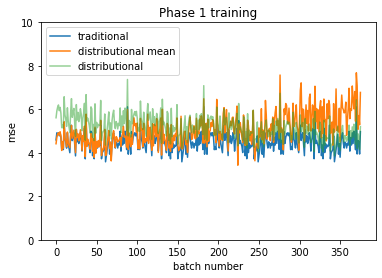

In [4]:
print("PHASE 1")
LABELS_REWARDS_PHASE_1 = { 2: [+3, -3],
                           4: [0]
                         }

print("Training traditional model (1 output)")
model_trad, loss_log_trad_1, _ = train(create_model(1),
                                    LABELS_REWARDS_PHASE_1,
                                    traditional_TD_loss)

print(f"Training distributional model ({N_ATOMS} outputs)")
model_dist, loss_log_dist_1, l21 = train(create_model(TAUS.size),
                                    LABELS_REWARDS_PHASE_1,
                                    expectile_distributional_TD_loss,
                                    tau_factors=TAU_FACTORS)

print("Plotting output...")
plt.title("Phase 1 training")
plt.ylabel("mse")
plt.xlabel("batch number")
plt.plot(loss_log_trad_1, label="traditional")
plt.plot(l21, label="distributional mean")
plt.plot(loss_log_dist_1, label="distributional", alpha=0.5)
plt.ylim([0, 10])
plt.legend()
plt.show()

PHASE 2
Re-training traditional model (from phase 1)


loss           2.330 (done)

Training distributional model (from phase 1)


loss           1.303 (done)

Plotting output...


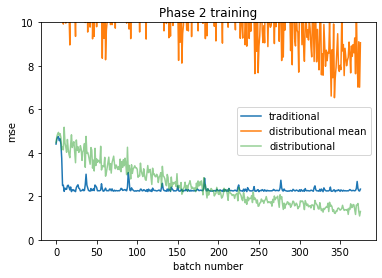

In [5]:
print("PHASE 2")
LABELS_REWARDS_PHASE_2 = { 2: [+3],
                           4: [0]
                         }

print("Re-training traditional model (from phase 1)")
model_trad, loss_log_trad_2, _ = train(model_trad,
                                    LABELS_REWARDS_PHASE_2,
                                    traditional_TD_loss)

print("Training distributional model (from phase 1)")
model_dist, loss_log_dist_2, l22 = train(model_dist,
                                    LABELS_REWARDS_PHASE_2,
                                    expectile_distributional_TD_loss,
                                    tau_factors=TAU_FACTORS)

print("Plotting output...")
plt.title("Phase 2 training")
plt.ylabel("mse")
plt.xlabel("batch number")
plt.plot(loss_log_trad_2, label="traditional")
plt.plot(l22, label="distributional mean")
plt.plot(loss_log_dist_2, label="distributional", alpha=0.5)
plt.ylim([0, 10])
plt.legend()
plt.show()

CONTROL
Training NEW traditional model (phase 2 rewards)


loss           2.314 (done)

Training NEW distributional model (phase 2 rewards)


loss           1.204 (done)

Plotting output...


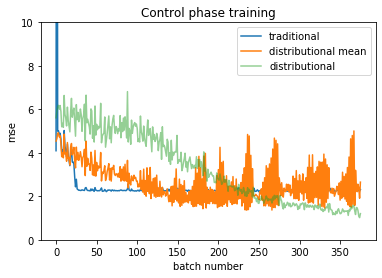

In [6]:
print("CONTROL")

print("Training NEW traditional model (phase 2 rewards)")
model_trad_control, loss_log_trad_C, _ = train(create_model(1),
                                            LABELS_REWARDS_PHASE_2,
                                            traditional_TD_loss)

print("Training NEW distributional model (phase 2 rewards)")
model_dist_control, loss_log_dist_C, l2C = train(create_model(TAUS.size),
                                            LABELS_REWARDS_PHASE_2,
                                            expectile_distributional_TD_loss,
                                            tau_factors=TAU_FACTORS)

print("Plotting output...")
plt.title("Control phase training")
plt.ylabel("mse")
plt.xlabel("batch number")
plt.plot(loss_log_trad_C, label="traditional")
plt.plot(l2C, label="distributional mean")
plt.plot(loss_log_dist_C, label="distributional", alpha=0.5)
plt.ylim([0, 10])
plt.legend()
plt.show()

Repeat all plots...


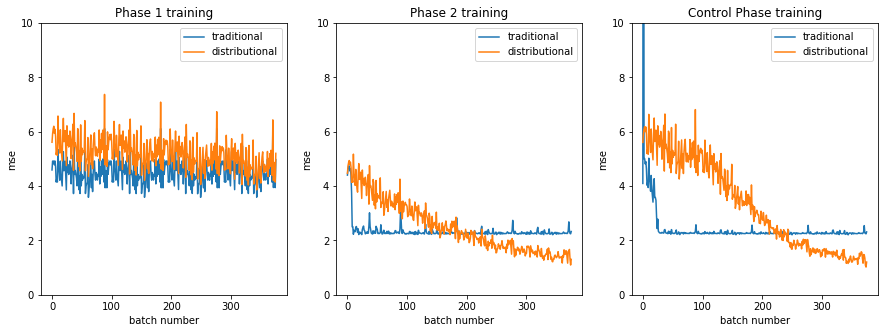

In [7]:
print("Repeat all plots...")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Phase 1 training")
ax1.set_ylabel("mse")
ax1.set_xlabel("batch number")
ax1.plot(loss_log_trad_1, label="traditional")
# ax1.plot(l21, label="distributional (mean)")
ax1.plot(loss_log_dist_1, label="distributional")
ax1.set_ylim([0, 10])
ax1.legend()
ax2.set_title("Phase 2 training")
ax2.set_ylabel("mse")
ax2.set_xlabel("batch number")
ax2.plot(loss_log_trad_2, label="traditional")
# ax2.plot(l22, label="distributional (mean)")
ax2.plot(loss_log_dist_2, label="distributional")
ax2.set_ylim([0, 10])
ax2.legend()
ax3.set_title("Control Phase training")
ax3.set_ylabel("mse")
ax3.set_xlabel("batch number")
ax3.plot(loss_log_trad_C, label="traditional")
# ax3.plot(l2C, label="distributional (mean)")
ax3.plot(loss_log_dist_C, label="distributional")
ax3.set_ylim([0, 10])
ax3.legend()
plt.show()